In [4]:
import os
from os import listdir
from os.path import join
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from IPython.display import display
import cv2 as cv
import matplotlib.pyplot as plt

In [5]:
size_input = 33 # 输入图像的大小 33
size_label = 21 # 标签图像的大小 21
scale = 3       # 下采样因子
stride = 14     # 提取子图像的步长
padding = abs(size_input - size_label)/2  # 

batch_size = 64

In [6]:
folder = os.path.abspath('.')
train_path = os.path.join(folder, 'paper_data\\Train')
test_path = os.path.join(folder, 'paper_data\\Test\\Set14')
folder, train_path

('d:\\home\\MyProject\\Paper\\Super-Resolution_CNN\\SRCNN_torch',
 'd:\\home\\MyProject\\Paper\\Super-Resolution_CNN\\SRCNN_torch\\paper_data\\Train')

In [7]:
def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

def modcrop(img, scale):
    #获取图像的宽和高
    w, h = img.size
    #对高度和宽度分别取余并计算出最大整数值
    h1 = int(h/scale) * scale
    w1 = int(w/scale) * scale
    #将图像裁剪到指定的宽度和高度
    return img.crop((0, 0, w1, h1))

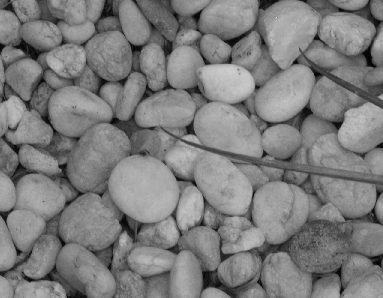

(383, 298)


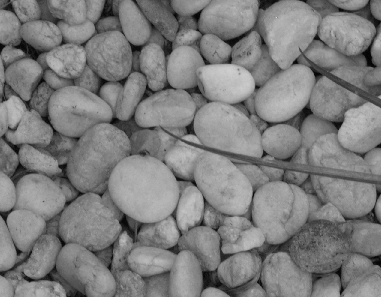

<PIL.Image.Image image mode=L size=381x297 at 0x1EC77F615D0>


In [5]:
example_img = 'd:\\home\\MyProject\\Paper\\Super-Resolution_CNN\\SRCNN_torch\\paper_data\\Train\\tt12.bmp'
example_img = load_img(example_img)
display(example_img)
print(example_img.size) # width, height
example_img = modcrop(example_img, 3)
display(example_img)
print(example_img)

In [6]:
class SRCNNDataset(Dataset):
    def __init__(self, image_dir, scale) -> None:
        super().__init__()
        # 获取目录中的所有文件
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if x.endswith('.bmp')]
        self.totensor = transforms.ToTensor()
        self.inputs = []
        self.labels = []
        self.operate_img()
    
    def __getitem__(self, index):
        input = self.totensor(self.inputs[index])
        label = self.totensor(self.labels[index])
        return input, label
        
    def __len__(self):
        return len(self.inputs)
        
    def operate_img(self):
        for image in self.image_filenames:
            input = load_img(image) # 获取y通道
            # print(f'获取图片的y通道：{input}')
            # display(input)
            # 将图片裁剪为与scale匹配的大小。裁剪舍掉余数行和列。
            im_label = modcrop(input, scale=scale)
            # print(f'裁剪多余行列：{im_label}')
            # display(im_label)
            # 获取裁剪后图像的大小
            width, height = im_label.size
            # 将标签图片下采样得到缩放后的输入图片
            im_input = ImageOps.scale(im_label, 1/scale, 
                                      resample=Image.Resampling.BICUBIC)
            # print(f'下采样：{im_input}')
            # display(im_input)
            # 将输入图片上采样得到低分辨率图片
            im_input = ImageOps.contain(im_input, (width, height), 
                                      method=Image.Resampling.BICUBIC)
            # print(f'上采样：{im_input}')
            # display(im_input)
            for x in range(1, height - size_input + 1, stride):
                for y in range(1, width - size_input + 1, stride):
                    subim_input = im_input.crop((x, y, x + size_input - 1, 
                                                 y + size_input - 1))
                    
                    subim_label = im_label.crop((x + padding, y + padding, 
                                                 x + padding + size_label - 1,
                                                 y + padding + size_label - 1))
                    self.inputs.append(subim_input)
                    self.labels.append(subim_label)
            #         print(f'输入图片：{subim_input}')
            #         display(subim_input)
            #         print(f'标签图片：{subim_label}')
            #         display(subim_label)
            #         break
            #     break
            # break
        

In [7]:
data = SRCNNDataset(train_path, scale)

In [8]:
train_dataset = SRCNNDataset(train_path, scale=scale)
print(len(train_dataset))
test_dataset = SRCNNDataset(test_path, scale=scale)
print(len(test_dataset))

21712
14851


## model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from math import log10

class SRCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=0)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=0)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        
        return out

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)  # 设置PyTorch中所有随机数生成器的种子为0
torch.cuda.manual_seed(0) # 设置使用CUDA时的随机数生成器的种子为0

print(device)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)
print(f'dataloader batch: {len(train_dataloader)}')

cuda


NameError: name 'train_dataset' is not defined

In [11]:
model = SRCNN().to(device)

loss_fn = nn.MSELoss()

optimizer = optim.SGD(
    [
        {'params': model.conv1.parameters(), 'lr': 0.0001},
        {'params': model.conv2.parameters(), 'lr': 0.0001},
        {'params': model.conv3.parameters(), 'lr': 0.00001}
    ], lr=0.0001, momentum=0.9
)

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train
    
    for batch, (X, y) in enumerate(dataloader):
        input, target = X.to(device), y.to(device)
        pred = model(input)
        loss = loss_fn(pred, target)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    avg_psnr = 0
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            input, target = X.to(device), y.to(device)
            
            pred = model(input)
            loss = loss_fn(pred, target)
            test_loss += loss.item()
            psnr = 10 * log10(1 / loss.item())
            avg_psnr += psnr
    test_loss /= num_batches
    avg_psnr /= num_batches
    print(f'Test Error: \n PSNR:{(avg_psnr):>0.5f}, Avg loss: {test_loss:>8f} \n')
    

In [13]:
epochs = 5000

for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n--------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print('Done!')
torch.save(model.state_dict(), 'srcnn_e5000_s3_set14.pth')

Epoch 1
--------------------------


loss: 0.257291 [   64/21712]
loss: 0.190167 [ 6464/21712]
loss: 0.117998 [12864/21712]
loss: 0.073669 [19264/21712]
Test Error: 
 PSNR:12.21542, Avg loss: 0.073527 

Epoch 2
--------------------------
loss: 0.061219 [   64/21712]
loss: 0.039964 [ 6464/21712]
loss: 0.018358 [12864/21712]
loss: 0.018840 [19264/21712]
Test Error: 
 PSNR:18.95854, Avg loss: 0.014774 

Epoch 3
--------------------------
loss: 0.014990 [   64/21712]
loss: 0.012697 [ 6464/21712]
loss: 0.010873 [12864/21712]
loss: 0.011980 [19264/21712]
Test Error: 
 PSNR:19.94601, Avg loss: 0.011847 

Epoch 4
--------------------------
loss: 0.012241 [   64/21712]
loss: 0.010303 [ 6464/21712]
loss: 0.009559 [12864/21712]
loss: 0.010689 [19264/21712]
Test Error: 
 PSNR:20.47855, Avg loss: 0.010597 

Epoch 5
--------------------------
loss: 0.008559 [   64/21712]
loss: 0.008146 [ 6464/21712]
loss: 0.009153 [12864/21712]
loss: 0.007923 [19264/21712]
Test Error: 
 PSNR:20.92814, Avg loss: 0.009679 

Epoch 6
----------------------

## PSNR 

In [14]:
set5_test_path = os.path.join(folder, 'paper_data\\Test\\Set5')
set5_test_dataset = SRCNNDataset(set5_test_path, scale=scale)
set5_test_dataloader = DataLoader(dataset=set5_test_dataset, batch_size=batch_size)
test_loop(set5_test_dataloader, model, loss_fn)

Test Error: 
 PSNR:32.66751, Avg loss: 0.001005 



高分辨率图片：<PIL.Image.Image image mode=L size=305x256 at 0x1BEAACFF610>


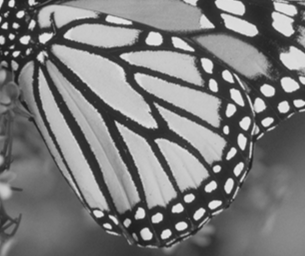

低分辨率图片：<PIL.Image.Image image mode=L size=915x768 at 0x1BEAACFF9D0>


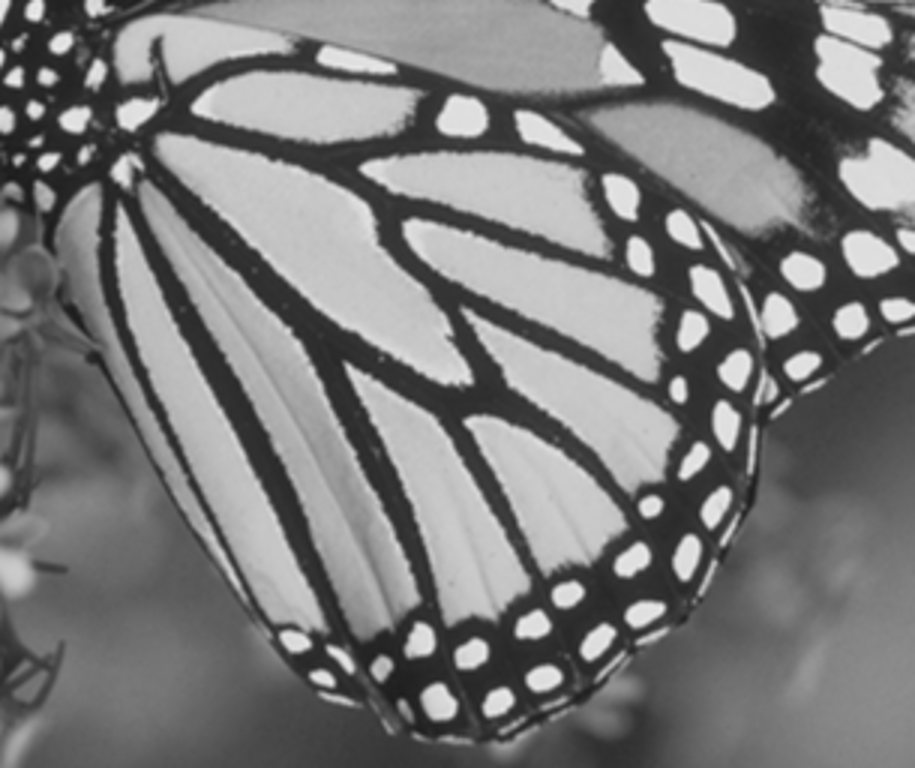

x:756  y:903


In [15]:
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_srcnn_e5000 = SRCNN()
model_srcnn_e5000.load_state_dict(torch.load('srcnn_e5000_s3_set14.pth'))
model_srcnn_e5000 = model_srcnn_e5000.to(device)

example_img = 'd:\\home\\MyProject\\Paper\\Super-Resolution_CNN\\SRCNN_torch\\monarch.bmp'

tmp_input = load_img(example_img) # 获取y通道
print(f'高分辨率图片：{tmp_input}')
display(tmp_input)
tmp_input = ImageOps.scale(tmp_input, scale, 
                        resample=Image.Resampling.BICUBIC)
print(f'低分辨率图片：{tmp_input}')
display(tmp_input)

tmp_input = transforms.ToTensor()(tmp_input)  
model_srcnn_e5000.eval()
with torch.no_grad():
    tmp_input = tmp_input.to(device)
    
    pred = model_srcnn_e5000(tmp_input)
_, x, y = pred.size()
print(f'x:{x}  y:{y}')

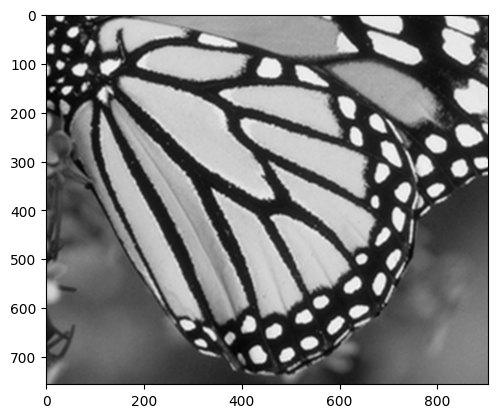

In [16]:
tmp_pred = torch.Tensor.cpu(pred)
plt.imshow(tmp_pred.reshape(x, y), cmap='gray')
plt.show()

<PIL.Image.Image image mode=L size=101x85 at 0x1EC16428190>


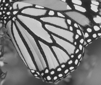

低分辨率图片：<PIL.Image.Image image mode=L size=303x255 at 0x1EC1642ADD0>


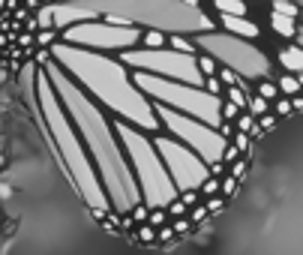

高分辨率图片：<PIL.Image.Image image mode=L size=303x255 at 0x1EC164282E0>


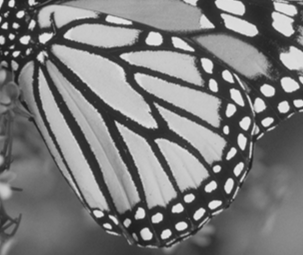

Test Error: 
 PSNR:0.00243, Avg loss: 26.151131 

torch.Size([1, 255, 303])


In [25]:
model_psnr23_7 = torch.load('SRCNN_model_psnr23.7.pth').to(device)

def operate_img_byparam(image, scale, padding):
        input = load_img(image) # 获取y通道
        # print(input)
        # display(input)
        # 将图片裁剪为与scale匹配的大小。裁剪舍掉余数行和列。
        im_label = modcrop(input, scale=scale)
        # print(im_label)
        # display(im_label)
        # 获取裁剪后图像的大小
        width, height = im_label.size
        im_input = ImageOps.scale(im_label, 1/scale, 
                                    resample=Image.Resampling.BICUBIC)
        print(im_input)
        display(im_input)
        im_input = ImageOps.contain(im_input, (width, height), 
                                    method=Image.Resampling.BICUBIC)
        im_label = im_label.crop((padding, padding, width - padding , height - padding))
        print(f'低分辨率图片：{im_input}')
        display(im_input)
        print(f'高分辨率图片：{im_label}')
        display(im_label)
        return im_input, im_label

tmp_input, tmp_label = operate_img_byparam(example_img, 3, 0)
tmp_input = transforms.ToTensor()(tmp_input)
tmp_label = transforms.ToTensor()(tmp_label)

model_psnr23_7.eval()
with torch.no_grad():
    tmp_input, tmp_label = tmp_input.to(device), tmp_label.to(device)
    
    pred = model_psnr23_7(tmp_input)
    loss = loss_fn(pred, tmp_label)
    test_loss = loss.item()
    psnr = 10 * log10(1 / loss.item())
print(f'Test Error: \n PSNR:{(test_loss):>0.5f}, Avg loss: {psnr:>8f} \n')

print(pred.size())


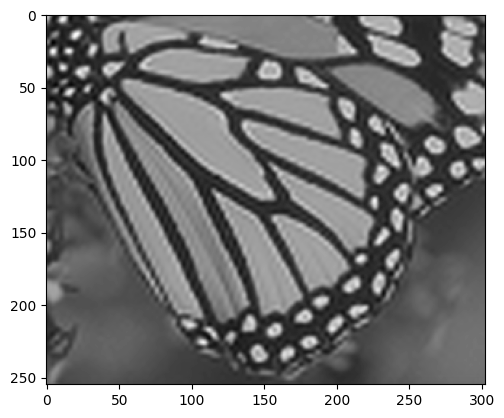

In [27]:
tmp_pred = pred.cpu()
plt.imshow(tmp_pred.reshape(255, 303), cmap='gray')
plt.show()